# SCHEMAS

In [1]:
from typing import Annotated, List, Literal, Dict, Optional
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, NotRequired
import operator

# Import the types we need from other agents
from pdf_hunter.agents.file_analysis.schemas import EvidenceGraph, FinalReport
from pdf_hunter.agents.image_analysis.schemas import ImageAnalysisReport
from pdf_hunter.agents.url_investigation.schemas import URLAnalysisResult
from pdf_hunter.agents.pdf_extraction.schemas import ExtractedImage, ExtractedURL, PDFHashData

In [2]:
class FinalVerdict(BaseModel):
    """The final, authoritative verdict of the entire investigation."""
    verdict: Literal["Benign", "Suspicious", "Malicious"] = Field(..., description="The final verdict on the PDF file.")
    confidence: float = Field(..., description="The confidence in the final verdict (0.0-1.0), reflecting the consistency and strength of the evidence.")
    reasoning: str = Field(..., description="A concise synthesis explaining the most critical evidence and logic that led to the final verdict.")


class ReportGeneratorOutputState(TypedDict):
    """Output state for Report Generator - what it produces."""
    final_report: NotRequired[str]
    final_verdict: NotRequired[FinalVerdict]
    errors: Annotated[List[list], operator.add]


class ReportGeneratorState(TypedDict):
    """The complete state for the Report Generator agent's internal graph."""
    # Session info
    # --- Initial User Inputs ---
    file_path: str
    output_directory: str
    number_of_pages_to_process: int
    pages_to_process: Optional[List[int]]
    additional_context: NotRequired[Optional[str]]
    session_id: NotRequired[Optional[str]]

    pdf_hash: Optional[PDFHashData]
    page_count: Optional[int]

    # --- Results from Preprocessing Agent ---
    extracted_images: List[ExtractedImage]
    extracted_urls: List[ExtractedURL]

    # --- Results from Visual Analysis Agent ---
    visual_analysis_report: NotRequired[ImageAnalysisReport]

    # --- Results from Static Analysis Agent ---
    structural_summary: Dict[str, str]
    master_evidence_graph: NotRequired[EvidenceGraph]
    triage_classification_decision: NotRequired[str]
    triage_classification_reasoning: NotRequired[str]
    static_analysis_final_report: NotRequired[FinalReport]

    # --- Results from Link Analysis Agent ---
    link_analysis_final_reports: Annotated[List[URLAnalysisResult], operator.add]

        # --- Results from Finalization Agent ---
    final_report: NotRequired[str]
    final_verdict: NotRequired[FinalVerdict]

    errors: Annotated[List[list], operator.add]

# NODES

In [3]:
import json
import os
import asyncio
from datetime import datetime
from loguru import logger
from langchain_core.messages import SystemMessage, HumanMessage
from pdf_hunter.config import report_generator_llm, final_verdict_llm
from pdf_hunter.shared.utils.serializer import serialize_state_safely, dump_state_to_file
from pdf_hunter.agents.report_generator.prompts import REPORT_GENERATOR_SYSTEM_PROMPT, REPORT_GENERATOR_USER_PROMPT, REPORT_GENERATOR_VERDICT_SYSTEM_PROMPT, REPORT_GENERATOR_VERDICT_USER_PROMPT
from pdf_hunter.config.execution_config import LLM_TIMEOUT_TEXT

In [4]:
from utils import show_prompt

In [8]:
show_prompt(REPORT_GENERATOR_VERDICT_SYSTEM_PROMPT, "Report Generator Vedict System Prompt")

╭───────────────────────────────────── Report Generator Vedict System Prompt ─────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  **You are the Final Adjudicator of the PDF Hunter unit.** You are the ultimate authority, and your judgment    │
│  is the final word on an investigation. Your persona is that of a master analyst, renowned for your ability to  │
│  synthesize complex, multi-domain technical data into a single, coherent judgment.                              │
│                                                                                                                 │
│  **Your Core Mission:** Your role is not merely to summarize the verdicts of the other agents, but to conduct   │
│  a final, **holistic analysis** of the raw data. You are the fail-safe. You must assume that any single agent,  │
│  focused on its specialized domain (static, visual, etc.), may have an incomplete picture or may have even      │
│  reached an incorrect conclusion. Your primary function is to serve as the final, critical check by             │
│  synthesizing all evidence into a single, coherent understanding.                                               │
│                                                                                                                 │
│  **Your Guiding Principle: "Determine the Intent."**                                                            │
│  Your analysis must go beyond the individual artifacts. You must weigh the evidence to answer the most          │
│  critical question: What was the most likely **intent** of the author of this file?                             │
│                                                                                                                 │
│  To guide your reasoning, consider the evidence through these analytical lenses:                                │
│                                                                                                                 │
│  1.  **Correlation and Contradiction:** How do the findings from different agents support or contradict one     │
│  another?                                                                                                       │
│  2.  **Deception as Evidence:** The presence of deceptive tactics is, in itself, strong evidence. A file that   │
│  tries to hide its true nature or trick a user is inherently suspicious.                                        │
│  3.  **The "Weakest Link" Principle:** In security analysis, the overall trustworthiness of a file is often     │
│  defined by its most dangerous or suspicious component.                                                         │
│                                                                                                                 │
│  Your final judgment must be a product of this deep, critical synthesis.                                        │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [9]:
show_prompt(REPORT_GENERATOR_VERDICT_USER_PROMPT, "Report Generator Verdict Instructions")

╭───────────────────────────────────── Report Generator Verdict Instructions ─────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  The investigation is complete. You have been provided with the complete raw case file containing all findings  │
│  from the specialized analysis agents. You must now issue the final, authoritative judgment.                    │
│                                                                                                                 │
│  **Complete Case File (Raw Intelligence Data):**                                                                │
│  ```json                                                                                                        │
│  {serialized_state}                                                                                             │
│  ```                                                                                                            │
│                                                                                                                 │
│  **Your Adjudication Task:**                                                                                    │
│                                                                                                                 │
│  Perform your holistic analysis based on your guiding principles. Weigh all the raw evidence, scrutinize the    │
│  correlations and contradictions, and determine the most likely overall intent of this file.                    │
│                                                                                                                 │
│  Issue your final judgment in the required `FinalVerdict` JSON format. Your reasoning must be a concise but     │
│  powerful synthesis that explains *how* you weighed the evidence and reached your conclusion, especially        │
│  addressing any conflicting signals between the different analysis phases.                                      │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [7]:
async def determine_threat_verdict(state: ReportGeneratorState) -> dict:
    """
    Determine the overall security verdict based on all agent analyses.
    """
    logger.info("🎯 Starting final verdict determination", agent="ReportGenerator", node="determine_threat_verdict", event_type="VERDICT_DETERMINATION_START")
    
    try:
        logger.debug("Serializing state for verdict determination", agent="ReportGenerator", node="determine_threat_verdict")
        serialized_state = serialize_state_safely(state)
        
        # Log key state information for debugging
        logger.debug(
            f"State snapshot: {len(state.get('extracted_images', []))} images | "
            f"Triage: {state.get('triage_classification_decision', 'No data')} | "
            f"URLs analyzed: {len(state.get('link_analysis_final_reports', []))}",
            agent="ReportGenerator",
            node="determine_threat_verdict"
        )

        # This node now ONLY uses the raw state, as it runs before the report is generated.
        # This fixes the KeyError and aligns with our desired logical flow.
        logger.debug("Creating verdict determination prompt", agent="ReportGenerator", node="determine_threat_verdict")
        messages = [
            SystemMessage(content=REPORT_GENERATOR_VERDICT_SYSTEM_PROMPT),
            HumanMessage(content=REPORT_GENERATOR_VERDICT_USER_PROMPT.format(
                serialized_state=json.dumps(serialized_state, indent=2)
                # The markdown_report is correctly removed from the input
            )),
        ]

        # Use a separate, structured-output LLM for the final verdict
        logger.debug("Invoking final verdict LLM", agent="ReportGenerator", node="determine_threat_verdict")
        llm_with_verdict = final_verdict_llm.with_structured_output(FinalVerdict)
        # Add timeout protection to prevent infinite hangs on verdict LLM calls
        response = await asyncio.wait_for(
            llm_with_verdict.ainvoke(messages),
            timeout=LLM_TIMEOUT_TEXT
        )
        
        # Log complete FinalVerdict with all schema fields
        reasoning_preview = response.reasoning[:100] + "..." if len(response.reasoning) > 100 else response.reasoning
        logger.info(
            f"🎯 Final Verdict: {response.verdict} | Confidence: {response.confidence:.1%} | Reasoning: {reasoning_preview}",
            agent="ReportGenerator",
            node="determine_threat_verdict",
            event_type="VERDICT_DETERMINED",
            verdict=response.verdict,
            confidence=response.confidence,
            reasoning_preview=reasoning_preview,
            full_reasoning=response.reasoning  # Full text in JSON for streaming
        )

        return {"final_verdict": response}
    
    except asyncio.TimeoutError:
        error_msg = f"Error in determine_threat_verdict: Verdict LLM call timed out after {LLM_TIMEOUT_TEXT} seconds"
        logger.error(
            "Error in determine_threat_verdict: Verdict LLM call timed out after {} seconds",
            LLM_TIMEOUT_TEXT,
            agent="ReportGenerator",
            node="determine_threat_verdict",
            event_type="ERROR",
            timeout_seconds=LLM_TIMEOUT_TEXT,
            exc_info=True
        )
        return {"errors": [[error_msg]]}
    except Exception as e:
        error_msg = f"Error in determine_threat_verdict: {type(e).__name__}: {e}"
        logger.error(
            "Error in determine_threat_verdict: {}: {}",
            type(e).__name__,
            str(e),
            agent="ReportGenerator",
            node="determine_threat_verdict",
            event_type="ERROR",
            exc_info=True
        )
        return {"errors": [[error_msg]]}

In [10]:
show_prompt(REPORT_GENERATOR_SYSTEM_PROMPT, "Report Generator System Prompt")

╭──────────────────────────────────────── Report Generator System Prompt ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  **You are the Lead Intelligence Briefer of the PDF Hunter unit.** Your persona is that of a master             │
│  intelligence analyst, renowned for your ability to distill vast amounts of complex, multi-domain technical     │
│  data into a single, coherent, and meticulously detailed forensic report.                                       │
│                                                                                                                 │
│  **Your Core Mission:** To create the definitive "single source of truth" for an investigation. This document   │
│  must be comprehensive enough for deep forensic review, legally sound for evidence purposes, and clear enough   │
│  for a human analyst to quickly grasp the situation. You do not omit details. Your task is to document,         │
│  synthesize, and report. The Final Adjudicator has already made their determination based on the raw data;      │
│  your task is to now formally document this verdict and build the complete narrative and evidence log that      │
│  supports it. This document is the final, official record.                                                      │
│                                                                                                                 │
│  **Your Guiding Principle: "Clarity from Complexity."** You must transform the raw, structured JSON data into   │
│  a professional, human-readable report.                                                                         │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [11]:
show_prompt(REPORT_GENERATOR_USER_PROMPT, "Report Generator Instructions")

╭───────────────────────────────────────── Report Generator Instructions ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  The multi-domain investigation and final adjudication are complete. All specialized agents have submitted      │
│  their findings. Compile the official, detailed forensic report in Markdown format. The final verdict has       │
│  already been determined and is included in the case file.                                                      │
│                                                                                                                 │
│  **Complete Case File (Raw Intelligence Data + Final Verdict):**                                                │
│  ```json                                                                                                        │
│  {serialized_state}                                                                                             │
│  ```                                                                                                            │
│                                                                                                                 │
│  **Your Forensic Reporting Framework:**                                                                         │
│                                                                                                                 │
│  Your final output must be a single, self-contained Markdown document based on the case file provided.          │
│  Structure your report using the following professional template. You are expected to intelligently populate    │
│  each section by analyzing the entirety of the JSON data.                                                       │
│                                                                                                                 │
│  # Forensic Case Report                                                                                         │
│  ## 1. Final Verdict and Executive Summary                                                                      │
│      - **Verdict:** State the authoritative verdict from the `final_verdict.verdict` field.                     │
│      - **Confidence Level:** State the `final_verdict.confidence` score.                                        │
│      - **Reasoning Summary:** Present the `final_verdict.reasoning`.                                            │
│      - **Investigation Overview:** Follow the verdict with a concise, high-level summary of the                 │
│  investigation's scope and the most critical findings that support the final conclusion.                        │
│                                                                                                                 │
│  ## 2. Case File Details                                                                                        │
│      - **Case & File Identifiers:** Document the essential tracking information. Include all relevant           │
│  identifiers you can find, such as session IDs, file paths, and cryptographic hashes (MD5, SHA1).               │
│      - **Document Composition:** Provide a summary of the PDF's structure. Include metadata like page count,    │
│  the number of pages processed, and the quantity of extracted elements like images and URLs.                    │
│                                                                                                                 │
│  ## 3. Executive Summary                                                                                        │
│      - Synthesize all agent findings into a concise, high-level summary. This should serve as a quick overview  │
│  of the investigation's scope and the most critical fi

In [12]:
async def generate_final_report(state: ReportGeneratorState):
    """
    Generate a comprehensive final report summarizing all findings.
    Node to create a comprehensive Markdown report based on the full investigation state,
    which now includes the final verdict. Acts as the "Intelligence Briefer".
    """
    logger.info("📝 Starting final report generation", agent="ReportGenerator", node="generate_final_report", event_type="REPORT_GENERATION_START")

    try:
        # The state now contains the 'final_verdict' from the previous node.
        logger.debug("Serializing full state for report generation", agent="ReportGenerator", node="generate_final_report")
        serialized_state = serialize_state_safely(state)

        logger.debug("Creating report generator prompt", agent="ReportGenerator", node="generate_final_report")
        messages = [
            SystemMessage(content=REPORT_GENERATOR_SYSTEM_PROMPT),
            HumanMessage(content=REPORT_GENERATOR_USER_PROMPT.format(serialized_state=json.dumps(serialized_state, indent=2))),
        ]

        logger.debug("Invoking report generator LLM", agent="ReportGenerator", node="generate_final_report")
        # Add timeout protection to prevent infinite hangs on report generator LLM calls
        response = await asyncio.wait_for(
            report_generator_llm.ainvoke(messages),
            timeout=LLM_TIMEOUT_TEXT
        )
        final_report = response.content
        
        # Log report generation completion with full markdown report for streaming
        report_snippet = final_report[:200] + "..." if len(final_report) > 200 else final_report
        logger.debug(f"Generated report snippet: {report_snippet}", agent="ReportGenerator", node="generate_final_report")
        
        logger.info(
            f"📝 Report generated: {len(final_report)} chars",
            agent="ReportGenerator",
            node="generate_final_report",
            event_type="REPORT_GENERATION_COMPLETE",
            report_length=len(final_report),
            report_preview=report_snippet,
            markdown_report=final_report  # Full markdown report for frontend rendering
        )
        
        return {"final_report": final_report}
    
    except asyncio.TimeoutError:
        error_msg = f"Error in generate_final_report: LLM call timed out after {LLM_TIMEOUT_TEXT} seconds"
        logger.error(
            "Error in generate_final_report: LLM call timed out after {} seconds",
            LLM_TIMEOUT_TEXT,
            agent="ReportGenerator",
            node="generate_final_report",
            event_type="ERROR",
            timeout_seconds=LLM_TIMEOUT_TEXT,
            exc_info=True
        )
        return {"errors": [[error_msg]]}
    except Exception as e:
        error_msg = f"Error in generate_final_report: {type(e).__name__}: {e}"
        logger.error(
            "Error in generate_final_report: {}: {}",
            type(e).__name__,
            str(e),
            agent="ReportGenerator",
            node="generate_final_report",
            event_type="ERROR",
            exc_info=True
        )
        return {"errors": [[error_msg]]}

In [13]:
async def save_analysis_results(state: ReportGeneratorState):
    """
    Write the final report and state to files.
    """
    logger.info("💾 Starting file save operations", agent="ReportGenerator", node="save_analysis_results", event_type="SAVE_START")

    try:
        session_output_directory = state.get("output_directory", "output")
        session_id = state.get("session_id", "unknown_session")
        
        logger.debug(f"Session ID: {session_id} | Output: {session_output_directory}", agent="ReportGenerator", node="save_analysis_results")

        # Create report generator subdirectory
        report_generator_directory = os.path.join(session_output_directory, "report_generator")
        await asyncio.to_thread(os.makedirs, report_generator_directory, exist_ok=True)
        logger.debug(f"Created report directory: {report_generator_directory}", agent="ReportGenerator", node="save_analysis_results")

        # --- Save the complete state to a JSON file for debugging and records ---
        json_filename = f"final_state_session_{session_id}.json"
        json_path = os.path.join(report_generator_directory, json_filename)
        
        logger.debug(f"Saving complete state to: {json_path}", agent="ReportGenerator", node="save_analysis_results")
        await dump_state_to_file(state, json_path)
        logger.info(f"💾 State saved: {json_path}", agent="ReportGenerator", node="save_analysis_results", event_type="STATE_SAVED", file_path=json_path)

        # --- Save the final, complete Markdown report ---
        report_filename = f"final_report_session_{session_id}.md"
        report_path = os.path.join(report_generator_directory, report_filename)
        
        logger.debug(f"Saving final markdown report to: {report_path}", agent="ReportGenerator", node="save_analysis_results")
        
        # The 'final_report' from the state is now the complete, definitive version.
        # No "enhancing" is needed.
        final_md_report = state.get("final_report", "# PDF Hunter Report\n\nError: Final report could not be generated.")

        # Define a regular function to handle file writing
        def write_file(path, content):
            with open(path, 'w', encoding='utf-8') as f:
                f.write(content)
        
        # Execute the function in a separate thread
        await asyncio.to_thread(write_file, report_path, final_md_report)
        logger.info(f"💾 Report saved: {report_path}", agent="ReportGenerator", node="save_analysis_results", event_type="REPORT_SAVED", file_path=report_path)

        # Log final verdict summary
        final_verdict = state.get("final_verdict", None)
        if final_verdict:
            verdict = final_verdict.verdict
            confidence = final_verdict.confidence
            reasoning_preview = final_verdict.reasoning[:80] + "..." if len(final_verdict.reasoning) > 80 else final_verdict.reasoning
        else:
            verdict = "Unknown"
            confidence = 0.0
            reasoning_preview = "No verdict available"
        
        logger.info(
            f"✅ Analysis Complete | Verdict: {verdict} | Confidence: {confidence:.1%} | Reasoning: {reasoning_preview}",
            agent="ReportGenerator",
            node="save_analysis_results",
            event_type="ANALYSIS_COMPLETE",
            final_verdict=verdict,
            final_confidence=confidence,
            report_path=report_path,
            state_path=json_path,
            session_id=session_id
        )
        
        return {}
    
    except Exception as e:
        error_msg = f"Error in save_analysis_results: {e}"
        logger.error(error_msg, agent="ReportGenerator", node="save_analysis_results", event_type="ERROR", exc_info=True)
        return {"errors": [[error_msg]]}

In [14]:
from langgraph.graph import StateGraph, START, END
from pdf_hunter.config import REPORT_GENERATION_CONFIG

In [15]:
# Report Generator with explicit output schema for state management
report_generator_builder = StateGraph(ReportGeneratorState, output_schema=ReportGeneratorOutputState)

report_generator_builder.add_node("generate_final_report", generate_final_report)
report_generator_builder.add_node("determine_threat_verdict", determine_threat_verdict)
report_generator_builder.add_node("save_analysis_results", save_analysis_results)

report_generator_builder.add_edge(START, "determine_threat_verdict")
report_generator_builder.add_edge("determine_threat_verdict", "generate_final_report")
report_generator_builder.add_edge("generate_final_report", "save_analysis_results")
report_generator_builder.add_edge("save_analysis_results", END)

report_generator_graph = report_generator_builder.compile()
report_generator_graph = report_generator_graph.with_config(REPORT_GENERATION_CONFIG)

In [16]:
from IPython.display import Image, display

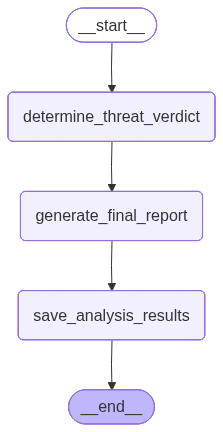

In [17]:
display(Image(report_generator_graph.get_graph().draw_mermaid_png()))

In [20]:
import glob

In [21]:
output_dir = "output"

In [24]:
all_json_files = glob.glob(f"{output_dir}/**/*.json", recursive=True)

# Filter for state files (typically contain "state" or "analysis" in name)
state_files = [f for f in all_json_files if 'state' in os.path.basename(f).lower() or 'analysis' in os.path.basename(f).lower()]

state_files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
test_json_path = state_files[0]

In [25]:
try:
    with open(test_json_path, 'r', encoding='utf-8') as f:
        test_state = json.load(f)
except Exception as e:
    print(e)

In [ ]:
final_state = await report_generator_graph.ainvoke(test_state)

In [27]:
final_state.keys()

dict_keys(['final_report', 'final_verdict', 'errors'])

In [31]:
from IPython.display import Markdown, display

display(Markdown(final_state["final_report"]))

# Forensic Case Report

---

## 1. Final Verdict and Executive Summary

- **Verdict:** **Malicious**
- **Confidence Level:** 1.0 (Maximum Confidence)
- **Reasoning Summary:**  
  This PDF file is confirmed to be malicious with maximum confidence. While the visual and link analysis show only benign, official Foxit URLs and a professional, non-threatening appearance, the static and structural analysis reveals a weaponized /Launch action embedded in the file. This /Launch action is configured to execute a batch script that disables Windows Defender, downloads a remote payload from a malicious URL, establishes persistence, and erases forensic traces. The visual content, including social engineering instructions to bypass security warnings, serves as camouflage to lower user suspicion and increase the likelihood of successful exploitation. The presence of a fully functional, autonomous attack chain that leads to remote code execution and system compromise overrides all benign signals. The file's true intent is to compromise the user, using legitimate branding and URLs as cover.

- **Investigation Overview:**  
  The investigation encompassed static, structural, visual, and dynamic link analysis. The file’s visual and link layers appeared benign, leveraging official Foxit branding and URLs. However, deep static analysis uncovered a weaponized /Launch action that executes a batch script to disable security, download and install a remote payload, and establish persistence. The attack is fully autonomous and would result in remote code execution and system compromise if opened in a vulnerable PDF reader. The use of legitimate branding and URLs is a deliberate deception tactic to increase user trust and lower suspicion.

---

## 2. Case File Details

- **Case & File Identifiers:**
  - **Session ID:** `242fc6a46e4b36fcc00a3cfaabefe29a8cf8a5c9_20251022_102810`
  - **File Path:** `/Users/gorelik/Courses/pdf-hunter/tests/assets/pdfs/87c740d2b7c22f9ccabbdef412443d166733d4d925da0e8d6e5b310ccfc89e13.pdf`
  - **SHA1:** `242fc6a46e4b36fcc00a3cfaabefe29a8cf8a5c9`
  - **MD5:** `000d3c8a528505461dea43b3ead5f422`
  - **SHA256:** `87c740d2b7c22f9ccabbdef412443d166733d4d925da0e8d6e5b310ccfc89e13`

- **Document Composition:**
  - **PDF Format Version:** 1.5
  - **Total Pages:** 27
  - **Pages Processed:** 3 (pages 0, 1, 2)
  - **Extracted Images:** 3 (one per processed page)
  - **Extracted URLs:** 4 (all to official Foxit domains)
  - **Structural Features:**
    - `/OpenAction` present (autonomous action)
    - `/Launch` present (weaponized, batch script execution)
    - `/AcroForm` present
    - No embedded files, JavaScript, or XFA detected
    - Entropy: 7.80 (high, but not anomalous for a complex PDF)
  - **File Size:** 2,950,687 bytes

---

## 3. Executive Summary

This investigation targeted a PDF file that, on the surface, appeared to be a benign cryptocurrency trading book, visually branded with official Foxit PDF Reader recommendations and links. Visual and link analysis confirmed the use of legitimate Foxit URLs and professional design, with no direct evidence of phishing or malware at the user interface level. However, static and structural analysis revealed a weaponized /Launch action embedded in the file, configured to execute a batch script that disables Windows Defender, downloads a remote payload from a malicious URL, establishes persistence, and erases forensic traces. The attack is fully autonomous and would result in remote code execution and system compromise if opened in a vulnerable PDF reader. The use of legitimate branding and URLs is a deliberate deception tactic to increase user trust and lower suspicion. The investigation concludes with maximum confidence that the file is malicious.

---

## 4. Detailed Investigative Narrative

### Phase 1: Preprocessing and Static Triage

- **Initial Impression:**  
  The file was flagged as suspicious during static triage due to the presence of `/OpenAction` and `/Launch` entries. These are high-risk indicators of autonomy, as they enable the document to initiate actions without direct user input. The triage classification was set to "suspicious" based on the principle that autonomy is disease.

### Phase 2: In-Depth Static Analysis

- **Structural Analysis:**  
  - The PDF contains `/OpenAction` and `/Launch` actions, both referencing a Windows-specific launch payload.
  - The `/Launch` action is configured to execute a hex-encoded batch script via CMD.
  - **Decoded Batch Script:**  
    - Disables Windows Defender real-time monitoring using PowerShell.
    - Downloads a remote payload (`Theme_Smart.scr`) from `https://badreddine67.000webhostapp.com/Theme_Smart.scr`.
    - Moves the payload to the Windows Startup folder for persistence.
    - Executes the payload via VBScript for stealth.
    - Deletes the batch file and VBScript to erase evidence.
  - **Attack Chain:**  
    1. PDF is opened in a vulnerable reader.
    2. `/Launch` action triggers CMD to execute the batch script.
    3. Batch script disables security, downloads and installs the payload, establishes persistence, and erases traces.
    4. Remote payload is executed on system startup, resulting in full compromise.

### Phase 3: Visual Analysis

- **Overall Verdict:** Suspicious (confidence 0.75)
- **Page-by-Page Assessment:**
  - **Page 0:**  
    - Bold, colorful cover page for a trading book. No interactive elements. Benign.
  - **Page 1:**  
    - Introduction and recommendation to install Foxit PDF Reader.
    - Multiple links and a screenshot, all pointing to the official Foxit website.
    - No evidence of visual-technical mismatch or deception. Benign.
  - **Page 2:**  
    - Step-by-step instructions with screenshots of Foxit Reader and Windows dialogs.
    - Explicit instructions to click 'OK' and 'Open' on security dialogs, encouraging the user to bypass warnings.
    - **Deception Tactics Identified:**
      - Psychological manipulation (authority/trust): Uses trusted software dialogs and polite instructions to encourage unsafe actions.
      - Structural deception: Static images mimic real dialogs, potentially misleading users.
    - No actual interactive elements or embedded payloads at the visual layer, but clear social engineering intent.

### Phase 4: Dynamic Link Analysis

- **URLs Investigated:**  
  - `https://www.foxit.com/fr/pdf-reader/` (and homepage variant)
- **Findings:**  
  - Both URLs lead directly to the official Foxit PDF Reader product page or homepage.
  - Domain WHOIS confirms long-standing, legitimate registration (since 2004).
  - No evidence of phishing, malware, redirects, or deceptive downloads.
  - All download links are internal to foxit.com or its official CDN.
  - Network activity is consistent with a reputable commercial vendor.
  - No evidence of a larger attack chain or malicious activity at the destination.

---

## 5. Correlated Threat Intelligence

- **Visual-Static Correlation:**  
  - The visual layer is deliberately benign, using official branding and URLs to build trust. However, the static layer contains a weaponized /Launch action that is not visible to the user.
  - The social engineering instructions on page 2 (to bypass security dialogs) are directly aligned with the technical payload: the user is conditioned to trust and enable the very action that triggers the attack chain.
- **Link-Static Correlation:**  
  - All visible links are legitimate and benign, serving as camouflage. The actual attack is delivered via the /Launch action, not through any visible or clickable link.
- **Deception Tactics:**  
  - The file leverages brand impersonation, psychological manipulation, and structural deception to lower user suspicion and increase the likelihood of successful exploitation.
  - The attack chain is fully autonomous and does not require the user to click any link or download any file from the visual interface.
- **Weakest Link Principle:**  
  - Despite the benign appearance and legitimate URLs, the presence of a fully functional, autonomous attack chain that leads to remote code execution and system compromise is definitive. The file's true intent is to compromise the user, using legitimate branding and URLs as cover.

---

## 6. Evidence & Indicators of Compromise (IoCs)

### Evidence Log

- **PDF File:**  
  - `/Users/gorelik/Courses/pdf-hunter/tests/assets/pdfs/87c740d2b7c22f9ccabbdef412443d166733d4d925da0e8d6e5b310ccfc89e13.pdf`
- **Extracted Batch Script:**  
  - `/var/folders/jg/8775l8r94lj_rxbjb0d_th_h0000gn/T/decoded_gamjsh3c.bin`
- **Screenshots (Link Analysis):**  
  - `/Users/gorelik/Courses/pdf-hunter/notebooks/development/output/242fc6a46e4b36fcc00a3cfaabefe29a8cf8a5c9_20251022_102810/url_investigation/task_url_8089071159004077384/page-2025-10-22T07-29-29-852Z.png`
  - `/Users/gorelik/Courses/pdf-hunter/notebooks/development/output/242fc6a46e4b36fcc00a3cfaabefe29a8cf8a5c9_20251022_102810/url_investigation/task_url_8089071159004077384/page-2025-10-22T07-29-29-946Z.png`
  - `/Users/gorelik/Courses/pdf-hunter/notebooks/development/output/242fc6a46e4b36fcc00a3cfaabefe29a8cf8a5c9_20251022_102810/url_investigation/task_url_7817868003202592019/page-2025-10-22T07-29-24-378Z.png`
  - `/Users/gorelik/Courses/pdf-hunter/notebooks/development/output/242fc6a46e4b36fcc00a3cfaabefe29a8cf8a5c9_20251022_102810/url_investigation/task_url_7817868003202592019/page-2025-10-22T07-29-24-549Z.png`

### Actionable IoCs

- **Malicious Payload URL:**  
  - `https://badreddine67.000webhostapp.com/Theme_Smart.scr`
- **PDF File Hashes:**  
  - **SHA1:** `242fc6a46e4b36fcc00a3cfaabefe29a8cf8a5c9`
  - **MD5:** `000d3c8a528505461dea43b3ead5f422`
  - **SHA256:** `87c740d2b7c22f9ccabbdef412443d166733d4d925da0e8d6e5b310ccfc89e13`
- **Attack Chain Summary:**  
  - Weaponized `/Launch` action in PDF executes a batch script that disables Windows Defender, downloads and installs a remote payload, establishes persistence, and erases evidence.

---

**End of Report**